In [19]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os

from tqdm import tqdm_notebook
from shapely.geometry import Point, LineString


import matplotlib.pyplot as plt
%matplotlib inline

#data_path = '/home/fterroso/data/'
#tweets_path = '/home/fterroso/projects/twitter-crawler/streaming_tweets/'

import warnings
warnings.filterwarnings('ignore')

### Read census areas file

In [20]:
census_zones_gdf = gpd.read_file(os.path.join('data','agg_mun_tourist.geojson'),driver='GeoJSON')

In [21]:
census_zones_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
census_zones_gdf.head()

,primary_key,area_km2,Viv-total,hotels-total,camps-total,POB20,HOMBRES,MUJERES,Viv-per-area,hotels-per-area,camps-per-area,geometry
0,01001_AM,359.212,17.0,4.0,1.0,7470,3945,3525,0.047326,0.011135,0.002784,"POLYGON ((-2.46644 42.78842, -2.46983 42.78803..."
1,01002,96.348,8.0,1.0,1.0,10264,5044,5220,0.083032,0.010379,0.010379,"MULTIPOLYGON (((-2.97525 42.93816, -2.97702 42..."
2,01010_AM,197.821,17.0,0.0,0.0,5971,3021,2950,0.085936,0.000000,0.000000,"POLYGON ((-3.00076 43.06800, -3.00853 43.06362..."
3,01031_AM,372.013,50.0,18.0,1.0,7428,3851,3577,0.134404,0.048385,0.002688,"MULTIPOLYGON (((-2.48257 42.49991, -2.48180 42..."
4,01036,37.559,5.0,1.0,0.0,18118,8868,9250,0.133124,0.026625,0.000000,"POLYGON ((-2.93850 43.13864, -2.93541 43.13658..."


In [23]:
census_zones_gdf.shape

(2208, 12)

The attribute CUSEC (Código Unico de SECción) is the unique identifier of the sections

In [24]:
census_zones_gdf['primary_key'].nunique()

2208

In [25]:
census_zones_gdf.columns

Index(['primary_key', 'area_km2', 'Viv-total', 'hotels-total', 'camps-total',
       'POB20', 'HOMBRES', 'MUJERES', 'Viv-per-area', 'hotels-per-area',
       'camps-per-area', 'geometry'],
      dtype='object')

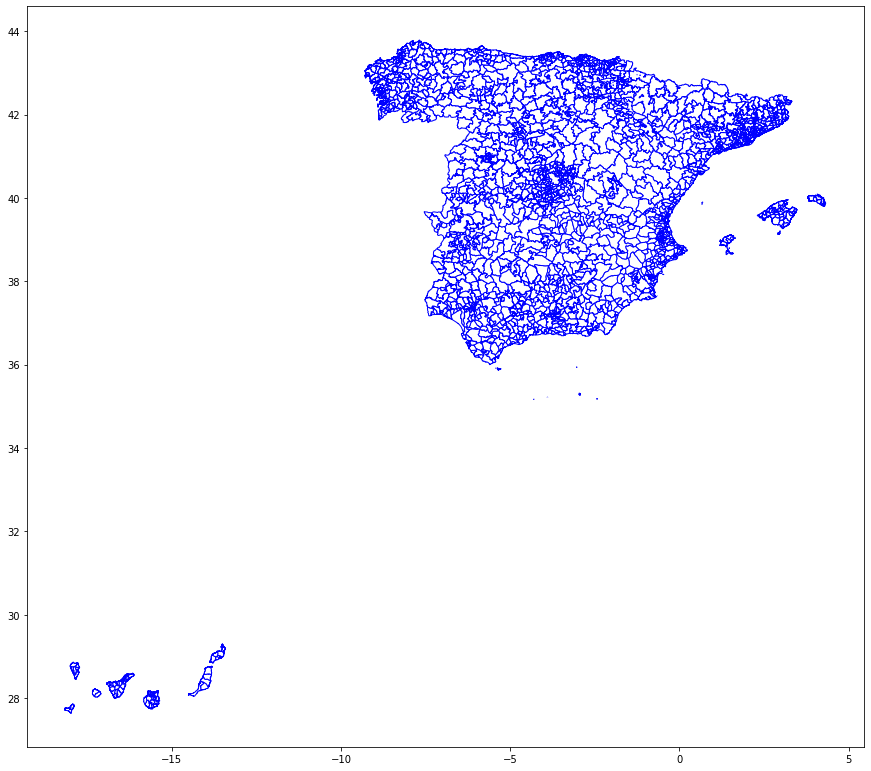

In [26]:
census_zones_gdf.plot(figsize=(15,15), color='white', edgecolor='blue');

## Process tweet geodataframes - census areas

In [27]:
import datetime
e_date = datetime.datetime.strptime('2021-04-30', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

In [28]:
from datetime import date, timedelta

delta = e_date - i_date       # as timedelta

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

#### Point based tweets

In [29]:
def map_point_tweets_with_census_area_fn(gdf_t):
    grilled_gdf = gpd.sjoin(gdf_t, census_zones_gdf['primary_key geometry'.split()], how="inner", op='intersects')
    grilled_gdf.drop(columns='index_right lat lon text'.split(),inplace=True)
    return grilled_gdf

In [30]:
for d in tqdm_notebook(target_days):
    day_for_file= d.strftime('%Y-%m-%d')

    file_path = os.path.join('data', 'TWT', 'processed','point_tweets_{}.geojson'.format(day_for_file))
    if os.path.exists(file_path):
        gdf = gpd.read_file(file_path, parse_dates=['timestamp'], driver='GeoJSON', encoding='utf-8').to_crs({'init': 'epsg:25830'})
        gdf = gdf.to_crs(4326)
        grilled_gdf = map_point_tweets_with_census_area_fn(gdf)
        grilled_gdf.to_file(os.path.join("data","TWT","mapped","map_point_tweets_{}.geojson".format(day_for_file)), driver='GeoJSON', encoding='utf-8')

  0%|          | 0/395 [00:00<?, ?it/s]

#### Polygon-based tweets

In [36]:
census_zones_gdf['area']= census_zones_gdf['geometry'].apply(lambda x: x.area)

In [37]:
census_zones_gdf.head()

,primary_key,area_km2,Viv-total,hotels-total,camps-total,POB20,HOMBRES,MUJERES,Viv-per-area,hotels-per-area,camps-per-area,geometry,area
0,01001_AM,359.212,17.0,4.0,1.0,7470,3945,3525,0.047326,0.011135,0.002784,"POLYGON ((-2.46644 42.78842, -2.46983 42.78803...",0.039479
1,01002,96.348,8.0,1.0,1.0,10264,5044,5220,0.083032,0.010379,0.010379,"MULTIPOLYGON (((-2.97525 42.93816, -2.97702 42...",0.010614
2,01010_AM,197.821,17.0,0.0,0.0,5971,3021,2950,0.085936,0.000000,0.000000,"POLYGON ((-3.00076 43.06800, -3.00853 43.06362...",0.021984
3,01031_AM,372.013,50.0,18.0,1.0,7428,3851,3577,0.134404,0.048385,0.002688,"MULTIPOLYGON (((-2.48257 42.49991, -2.48180 42...",0.040309
4,01036,37.559,5.0,1.0,0.0,18118,8868,9250,0.133124,0.026625,0.000000,"POLYGON ((-2.93850 43.13864, -2.93541 43.13658...",0.004139


In [38]:
max_cz_area = census_zones_gdf['area'].quantile(q=0.95)
max_cz_area

0.09279399592747148

In [39]:
def map_polygon_tweets_with_census_area_fn(gdf_t):
    
    #Firstly we remove the too-big tweets' polygons
    gdf_t['Shape_area']= gdf_t['geometry'].area
    gdf_ = gdf_t[gdf_t['Shape_area']< max_cz_area]
    
    #Census areas that contains tweets
    grilled_gdf1 = gpd.sjoin(census_zones_gdf['primary_key geometry'.split()], gdf_, how="inner", op='contains')
    try:
        grilled_gdf1.drop(columns='index_right text'.split(),inplace=True)
    except:
        grilled_gdf1.drop(columns=['index_right'],inplace=True)


    #Tweets that contains census areas
    grilled_gdf2 = gpd.sjoin(gdf_,census_zones_gdf['primary_key geometry'.split()], how="inner", op='contains')
    
    try:
        grilled_gdf2.drop(columns='index_right text'.split(),inplace=True)
    except:
        grilled_gdf2.drop(columns=['index_right'],inplace=True)
    
    
    #We just keep the tweets that conver only one census areas to avoid uncertainty.
    n_sec_per_tw = grilled_gdf2.groupby('tw_id')['primary_key'].nunique()
    tw_in_single_cmun_ids= n_sec_per_tw[n_sec_per_tw==1].index.to_list()
    grilled_gdf3 = grilled_gdf2[grilled_gdf2['tw_id'].isin(tw_in_single_cmun_ids)]

    grilled_gdf = pd.concat([grilled_gdf1, grilled_gdf3], axis=0)
    return grilled_gdf

In [ ]:
for d in tqdm_notebook(target_days):
    day_for_file= d.strftime('%Y-%m-%d')
    
    file_path = os.path.join('data', 'TWT', 'processed', 'poly_tweets_{}.geojson'.format(day_for_file))
    if os.path.exists(file_path):
        gdf = gpd.read_file(file_path, parse_dates=['timestamp'], driver='GeoJSON', encoding='utf-8').to_crs({'init': 'epsg:25830'})
        gdf = gdf.to_crs(4326)
        
        grilled_gdf = map_polygon_tweets_with_census_area_fn(gdf)
        grilled_gdf.to_file(os.path.join("data","TWT","mapped","map_poly_tweets_{}.geojson".format(day_for_file)), driver='GeoJSON', encoding='utf-8')

  0%|          | 0/395 [00:00<?, ?it/s]

In [ ]:
print("That's all folks!")